In [80]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [81]:
import os
import datetime

import pickle

import tensorflow as tf
import pandas as pd
import numpy as np
from deep_recommender_embeddings.src.ares import request_asset_from_ares
from deep_recommender_embeddings.src.elasticsearch_utils import get_es_instance, get_data_from_es, print_item
from deep_recommender_embeddings.src.image_embeddings import generate_image_embeddings
from deep_recommender_embeddings.src.models import ItemSimilarityModel
from deep_recommender_embeddings.src.plotting import plot_metric
from deep_recommender_embeddings.src.tf_utils import get_tf_lookup_table_for_property, get_tf_lookup_for_dict
from deep_recommender_embeddings.src.inference import get_dict_of_embeddings, build_annoy_index

%matplotlib inline

from annoy import AnnoyIndex

from deep_recommender_embeddings.src.preprocessing import load_data, clean_data, filter_logs, get_pairs, \
    get_item_pairs_from_journeys, generate_model_recs

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
#%reload_ext autoreload

#reload(deep_recommender_embeddings.src.tf_utils)

In [84]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


## Load content data from ES

In [92]:
_es_index = 'sfv_02112020'
_es_host = 'localhost'
_es_port = '9200'
es = get_es_instance(es_host=_es_host, es_port=_es_port)

# This is the imaginary date that recommendations will begenerated on
prediction_time = "2020-11-02T00:00:00"

# Business rules usually prevent recs being returned that are older than 90 days so we will only retrieve items
# that were published within this time window
max_age_days = 90

Now let's fetch all the relevant data from elasticsearch. For all items in the publication window we will fetch the id,
all the text, the tags, the category and the image url.

In [93]:
features = ["combinedBodySummaryHeadline","tagsText", "articleCategoryName", "thumbnailUrl"]
hits = get_data_from_es(es, features, 30000, 5000, prediction_time, max_age_days, _es_index)
unique_item_ids = [hit['sort'][0] for hit in hits]
print(f'Grabbed {len(unique_item_ids)} items from elasticsearch')

0
1
2
Grabbed 5060 items from elasticsearch


### Generate tensorflow lookup tables
Tensorflow requires special lookup tables to use in its graph so here we extract the relevant information into these
objects.

In [94]:
body_lookup_table, _ = get_tf_lookup_table_for_property(hits, "combinedBodySummaryHeadline", clean=True)
tags_lookup_table, _ = get_tf_lookup_table_for_property(hits, "tagsText")
category_lookup_table, unique_categories = get_tf_lookup_table_for_property(hits, "articleCategoryName")
thumbnail_lookup_table, _ = get_tf_lookup_table_for_property(hits, "thumbnailUrl")

Tensorflow lookup table created for combinedBodySummaryHeadline with 5060 entries.
Tensorflow lookup table created for tagsText with 3544 entries.
Tensorflow lookup table created for articleCategoryName with 4527 entries.
Tensorflow lookup table created for thumbnailUrl with 5060 entries.


### Generate image embeddings with pretrained model and save


In [95]:
model_link = 'https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4'
embeddings_fpath = '../data/embeddings/image/mobilenet_v2_140_224.pk'
IMAGE_SHAPE = (224,224)
generate_embeddings = False

if generate_embeddings:
    im_embeddings = generate_image_embeddings(model_link, thumbnail_lookup_table, IMAGE_SHAPE, unique_item_ids)
    with open(embeddings_fpath, 'wb') as f:
        pickle.dump(im_embeddings, f)
else:
    with open(embeddings_fpath, 'rb') as f:
        im_embeddings = pickle.load(f)

In [96]:
im_vec_lookup_table = get_tf_lookup_for_dict(im_embeddings)


Tensorflow lookup table created for vector dim=(1792,) with 5060 entries.


In [87]:
# inp = body_lookup_table.lookup(tf.convert_to_tensor(['/news/uk-england-nottinghamshire-54731548', '/news/election-us-2020-54754797']))
# TEXT_MODEL_LINK = 'https://tfhub.dev/tensorflow/albert_en_large/2'
# #TEXT_MODEL_LINK = 'https://tfhub.dev/google/nnlm-en-dim50/2'
# TEXT_MODEL_LINK = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1'

# text_model_embedding = tf.keras.Sequential([
#     hub.KerasLayer(TEXT_MODEL_LINK,input_shape=[],
#                 dtype=tf.string, trainable=False),
# #    tf.keras.layers.Embedding(input_dim=50, output_dim=embedding_dim, name="text_model_embedding_layer"),
# #    tf.keras.layers.GlobalAveragePooling1D(name="text_model_global_averaging_pooling_layer")
#     ])
# text_model_embedding(inp)


## Load the user data
Load the vocabulary of the of item IDs into a tensorflow dataset.

In [97]:
DATA_PATH = '/Users/mercef02/Projects/datasets_models/sfv_user_user_zoom_20201026_20201102/sfv_user*' #'/Users/mercef02/Projects/datasets/sfv_user_week_compact/*.csv'
logs = load_data(d_path=DATA_PATH, stop_after_n_files=1)
logs = clean_data(logs)

In [98]:
min_date = pd.to_datetime('2020-11-01T00:00:00')
max_date = pd.to_datetime('2020-11-01T11:59:59')
min_mentions = 5
train_logs = filter_logs(logs, min_date, max_date, min_mentions, unique_item_ids)

Original interactions: 2441510
Date filtered interactions: 161335
Minimum mention filtered interactions  : 146738
Interactions filtered for items existing in ES : 108230


### Generate item pairs 
The input for the model is pairs of consecutively consumed items so next we need to convert the journeys into item pairs

In [99]:
train_pairs = get_item_pairs_from_journeys(train_logs)
train_pairs_df = pd.DataFrame(train_pairs)
train_logs_tf = tf.data.Dataset.from_tensor_slices(dict(train_pairs_df))

Total number of item pairs: 6249


Let's visualise what some of these pairs of items look like that will be useful later for a sanity check.

In [100]:
train_pairs_df['shingled'] = train_pairs_df['item_a'] + '_' + train_pairs_df['item_b']
vc = train_pairs_df.shingled.value_counts()
train_pairs_df.head()

,item_a,item_b,shingled
0,/news/business-54746208,/news/world-asia-54734067,/news/business-54746208_/news/world-asia-54734067
1,/news/world-asia-54734067,/news/world-53405538,/news/world-asia-54734067_/news/world-53405538
2,/news/election-us-2020-54754800,/news/election-us-2020-54754652,/news/election-us-2020-54754800_/news/election...
3,/news/world-54754565,/sport/54122112,/news/world-54754565_/sport/54122112
4,/news/election-us-2020-54754800,/news/election-us-2020-54754797,/news/election-us-2020-54754800_/news/election...


<AxesSubplot:>

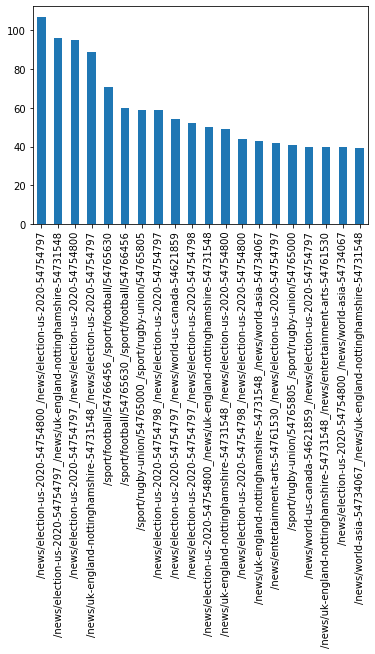

In [101]:
# Here we are visualising the histogram of the item pairs ordered by their frequency.
vc.head(20).plot(kind='bar')

### Holdout data

In [102]:

min_date = pd.to_datetime('2020-11-01T12:00:00')
max_date = pd.to_datetime('2020-11-02T00:00:00')
min_mentions = 5
holdout_logs = filter_logs(logs, min_date, max_date, min_mentions, unique_item_ids)
holdout_pairs = get_item_pairs_from_journeys(holdout_logs)
print(f"Total number of holdout item pairs: {len(holdout_pairs)}")
holdout_logs_tf = tf.data.Dataset.from_tensor_slices(dict(pd.DataFrame(holdout_pairs)))

Original interactions: 2441510
Date filtered interactions: 257384
Minimum mention filtered interactions  : 234998
Interactions filtered for items existing in ES : 171466
Total number of item pairs: 9824
Total number of holdout item pairs: 9824


## Train/Test Split

In [103]:
tf.random.set_seed(42)
training_shuffled = train_logs_tf.shuffle(buffer_size=100_000, seed=42, reshuffle_each_iteration=False)
train_pc = 0.9
test_pc = 0.1
sfv_train = training_shuffled.take(np.floor(len(training_shuffled)*train_pc))
sfv_val = training_shuffled.skip(np.floor(len(training_shuffled)*train_pc))
print(f'Number of train pairs: {len(sfv_train)}')
print(f'Number of test pairs: {len(sfv_val)}')


Number of train pairs: 5624
Number of test pairs: 625


## Training

Epoch 1/10
44/44 [==============================] - 5s 104ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0116 - factorized_top_k/top_5_categorical_accuracy: 0.0217 - factorized_top_k/top_10_categorical_accuracy: 0.0288 - factorized_top_k/top_50_categorical_accuracy: 0.0539 - factorized_top_k/top_100_categorical_accuracy: 0.0717 - loss: 5.0821 - regularization_loss: 0.0000e+00 - total_loss: 5.0821 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_loss: 4.7223 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.7223
Epoch 2/10
44/44 [==============================] - 5s 106ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized

Train accuracy: 0.09779516607522964
Validation accuracy: 0.1151999980211258
Hold out metrics:
77/77 [==============================] - 7s 95ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0051 - factorized_top_k/top_10_categorical_accuracy: 0.0092 - factorized_top_k/top_50_categorical_accuracy: 0.0353 - factorized_top_k/top_100_categorical_accuracy: 0.0837 - loss: 4.7524 - regularization_loss: 0.0000e+00 - total_loss: 4.7524
Holdout accuracy: 0.08367263525724411


[0.0030537459533661604,
 0.005089576356112957,
 0.009161237627267838,
 0.035321660339832306,
 0.08367263525724411,
 4.453891277313232,
 0,
 4.453891277313232]

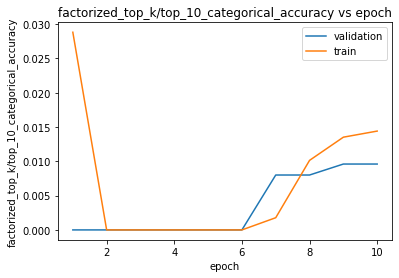

In [129]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
model = {"format": "text", "link": model_link}
num_epochs = 10
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_val.batch(128).cache()
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[1792],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[64],
                                      pretrained_text_model=model_link)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)


print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
plot_metric(one_layer_history, 'factorized_top_k/top_10_categorical_accuracy')
print("Hold out metrics:")
metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
print(f'Holdout accuracy: {metrics[4]}')
metrics


In [126]:
save_embeddings_fpath = '../data/embeddings/trained/body_category_64.pkl'
item_embeddings = get_dict_of_embeddings(model_one_layer, unique_item_ids, save_fpath=None)
annoy_index, id_to_uri, uri_to_id = build_annoy_index(item_embeddings)

In [131]:
_, values = im_vec_lookup_table.export()

In [134]:
values.numpy()[0].shape

(1792,)

In [127]:
#query_uri = '/news/technology-53018000'
#query_uri = '/sport/football/53805003'
#query_uri = '/news/business-10665047'
#query_uri = '/news/uk-england-hampshire-53838761'

query_uri, groundtruth_uri = vc.index[1].split('_')
print(f'query_uri = {query_uri}')
print(f'groundtruth_uri = {groundtruth_uri}')

rec_uris = generate_model_recs(query_uri, annoy_index, uri_to_id, id_to_uri, item_embeddings, es, _es_index, 20)
print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
print('-------------------')
print('-------------------')

for rec in rec_uris:
    print_item(rec, es, _es_index)
    print('-------------------')




query_uri = /news/election-us-2020-54754797
groundtruth_uri = /news/uk-england-nottinghamshire-54731548
Generating recommendations for:
/news/election-us-2020-54754797 
 Just ahead of the election, the US is seeing what could be the largest outbreak of the pandemic so far.
-------------------
-------------------
LITMUS TEST: False
-------------------
-------------------
/news/election-us-2020-54754797 
 Just ahead of the election, the US is seeing what could be the largest outbreak of the pandemic so far.
-------------------
/news/uk-england-cumbria-54283113 
 Barber John Ritson is urging people to stay safe after his friend Jimmy succumbed to coronavirus.
-------------------
/naidheachdan/54577901 
 Thòisich iomairt an t-seachdain seo gus clach-uaigh an t-seinneadair Gàidhlig Seasaidh NicLachlainn a stèidheachadh às ùr.
-------------------
/newsround/54246293 
 Eleven-year-old Austin is on a mission to get more people wearing clear face masks to help deaf people.
-------------------
/

In [ ]:
### Pretrained text model nnlm 50

### Pretrained text model nnlm 50

In [112]:
#model_link = 'https://tfhub.dev/google/nnlm-en-dim50/2'
#model_link = 'https://tfhub.dev/tensorflow/albert_en_large/2'
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

model = {"format": "text", "link": model_link}
recsys2 = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model'],
                                      feature_dims=[model],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      layer_sizes=[],
                                      pretrained_text_model=model_link)
recsys2.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_metrics = recsys2.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_metrics


Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2


552/552 [==============================] - 219s 397ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0271 - factorized_top_k/top_10_categorical_accuracy: 0.0426 - factorized_top_k/top_50_categorical_accuracy: 0.1208 - factorized_top_k/top_100_categorical_accuracy: 0.1472 - loss: 13.6282 - regularization_loss: 0.0000e+00 - total_loss: 13.6282


[0.001458283164538443,
 0.027098583057522774,
 0.042615849524736404,
 0.12076850235462189,
 0.14720165729522705]

### Pretrained image model 

In [286]:
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics


Using pretrained IMAGE model: https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4
552/552 [==============================] - 79s 143ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0031 - factorized_top_k/top_10_categorical_accuracy: 0.0120 - factorized_top_k/top_50_categorical_accuracy: 0.0499 - factorized_top_k/top_100_categorical_accuracy: 0.0787 - loss: 13.6808 - regularization_loss: 0.0000e+00 - total_loss: 13.6808


[0.0,
 0.003086463548243046,
 0.01203437615185976,
 0.04990726336836815,
 0.07871897518634796]

In [71]:
lr = 0.01
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[2048],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_vec_lookup_table,
                                      layer_sizes=[512, 100])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics


ValueError: in user code:

    <ipython-input-6-e48051f929fe>:177 call  *
        return self.dense_layers(feature_embedding)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__  **
        self.name)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:168 assert_input_compatibility
        layer_name + ' is incompatible with the layer: '

    ValueError: Input 0 of layer sequential_deep is incompatible with the layer: its rank is undefined, but the layer requires a defined rank.


### Pretrained image model and pretrained text model

In [287]:
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'

text_model = {"format": "text", "link": model_link}

recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model', 'image_embedding'],
                                      feature_dims=[text_model, None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())
recsys2_im_metrics

Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2
552/552 [==============================] - 197s 357ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0032 - factorized_top_k/top_10_categorical_accuracy: 0.0118 - factorized_top_k/top_50_categorical_accuracy: 0.0499 - factorized_top_k/top_100_categorical_accuracy: 0.0799 - loss: 13.6803 - regularization_loss: 0.0000e+00 - total_loss: 13.6803


[0.0,
 0.0031855700071901083,
 0.011836162768304348,
 0.049864791333675385,
 0.07985161989927292]

### Pretrained text model tuned on siamese network

In [318]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['text_model'],
                                      feature_dims=[text_model],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[64])
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

text_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
text_deep_metrics

Using pretrained TEXT model: https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2


Epoch 1/3


1704/1704 [==============================] - 503s 295ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0080 - factorized_top_k/top_10_categorical_accuracy: 0.0104 - factorized_top_k/top_50_categorical_accuracy: 0.0322 - factorized_top_k/top_100_categorical_accuracy: 0.0528 - loss: 5.5050 - regularization_loss: 0.0000e+00 - total_loss: 5.5050 - val_factorized_top_k/top_1_categorical_accuracy: 0.0034 - val_factorized_top_k/top_5_categorical_accuracy: 0.0132 - val_factorized_top_k/top_10_categorical_accuracy: 0.0135 - val_factorized_top_k/top_50_categorical_accuracy: 0.0477 - val_factorized_top_k/top_100_categorical_accuracy: 0.0808 - val_loss: 8.8002 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.8002
Epoch 2/3
1704/1704 [==============================] - 576s 338ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0160 - factorized_top_k/top_10_categorical_ac

[0.004573062993586063,
 0.018702836707234383,
 0.021690193563699722,
 0.05149297043681145,
 0.07713326811790466]

### Siamese network trained with item body text 

In [340]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
model_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['body'],
                                      feature_dims=[64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[],
                                      compute_metrics=True)
model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
model_one_layer.compute_metrics = True
text_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
text_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 636s 373ms/step - factorized_top_k/top_1_categorical_accuracy: 0.8308 - factorized_top_k/top_5_categorical_accuracy: 0.8766 - factorized_top_k/top_10_categorical_accuracy: 0.8979 - factorized_top_k/top_50_categorical_accuracy: 0.9320 - factorized_top_k/top_100_categorical_accuracy: 0.9441 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.2928 - val_factorized_top_k/top_5_categorical_accuracy: 0.4839 - val_factorized_top_k/top_10_categorical_accuracy: 0.4937 - val_factorized_top_k/top_50_categorical_accuracy: 0.4972 - val_factorized_top_k/top_100_categorical_accuracy: 0.5209 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 555s 326ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4317 - factorized_top_k/top_5_categorical_accuracy: 0.4521 - factorized_top_k/top_10_categorical_ac

[0.0,
 8.494853682350367e-05,
 0.00016989707364700735,
 0.0017272868426516652,
 0.1595899760723114]

### Siamese network trained with item tags text

In [342]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags'],
                                      feature_dims=[64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = tags_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_deep_metrics = model_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
tags_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 296s 174ms/step - factorized_top_k/top_1_categorical_accuracy: 0.7071 - factorized_top_k/top_5_categorical_accuracy: 0.7391 - factorized_top_k/top_10_categorical_accuracy: 0.7437 - factorized_top_k/top_50_categorical_accuracy: 0.7478 - factorized_top_k/top_100_categorical_accuracy: 0.7514 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.1431 - val_factorized_top_k/top_5_categorical_accuracy: 0.1450 - val_factorized_top_k/top_10_categorical_accuracy: 0.1528 - val_factorized_top_k/top_50_categorical_accuracy: 0.1528 - val_factorized_top_k/top_100_categorical_accuracy: 0.1528 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 308s 181ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4259 - factorized_top_k/top_5_categorical_accuracy: 0.4719 - factorized_top_k/top_10_categorical_ac

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [344]:
tags_deep_metrics = tags_one_layer.evaluate(holdout_logs_tf.batch(128).cache())

552/552 [==============================] - 89s 161ms/step - factorized_top_k/top_1_categorical_accuracy: 0.9632 - factorized_top_k/top_5_categorical_accuracy: 0.9808 - factorized_top_k/top_10_categorical_accuracy: 0.9857 - factorized_top_k/top_50_categorical_accuracy: 0.9872 - factorized_top_k/top_100_categorical_accuracy: 0.9876 - loss: 4.8512 - regularization_loss: 0.0000e+00 - total_loss: 4.8512


### Siamese network trained with item tags text and body

In [345]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_text_siamese = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_text_siamese.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_text_history = tags_text_siamese.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_text_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_text_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_text_metrics = tags_text_siamese.evaluate(holdout_logs_tf.batch(128).cache())
tags_text_metrics

Epoch 1/3


1704/1704 [==============================] - 723s 424ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0140 - factorized_top_k/top_5_categorical_accuracy: 0.0587 - factorized_top_k/top_10_categorical_accuracy: 0.0695 - factorized_top_k/top_50_categorical_accuracy: 0.0869 - factorized_top_k/top_100_categorical_accuracy: 0.0950 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.0088 - val_factorized_top_k/top_5_categorical_accuracy: 0.3333 - val_factorized_top_k/top_10_categorical_accuracy: 0.4036 - val_factorized_top_k/top_50_categorical_accuracy: 0.6738 - val_factorized_top_k/top_100_categorical_accuracy: 0.9617 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 653s 383ms/step - factorized_top_k/top_1_categorical_accuracy: 0.6046 - factorized_top_k/top_5_categorical_accuracy: 0.6613 - factorized_top_k/top_10_categorical_ac

[4.2474268411751837e-05,
 0.0003964265051763505,
 0.0003964265051763505,
 0.0016564964316785336,
 0.002067080931738019]

### Deep Siamese network trained with item tags text and body

In [346]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['tags', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 746s 438ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3441 - factorized_top_k/top_5_categorical_accuracy: 0.6136 - factorized_top_k/top_10_categorical_accuracy: 0.6474 - factorized_top_k/top_50_categorical_accuracy: 0.6939 - factorized_top_k/top_100_categorical_accuracy: 0.7140 - loss: 4.8505 - regularization_loss: 0.0000e+00 - total_loss: 4.8505 - val_factorized_top_k/top_1_categorical_accuracy: 0.0950 - val_factorized_top_k/top_5_categorical_accuracy: 0.9800 - val_factorized_top_k/top_10_categorical_accuracy: 0.9807 - val_factorized_top_k/top_50_categorical_accuracy: 0.9846 - val_factorized_top_k/top_100_categorical_accuracy: 0.9849 - val_loss: 3.9120 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.9120
Epoch 2/3
1704/1704 [==============================] - 690s 405ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2354 - factorized_top_k/top_5_categorical_accuracy: 0.4494 - factorized_top_k/top_10_categorical_ac

[0.00788605585694313,
 0.01687644235789776,
 0.016890600323677063,
 0.01694723218679428,
 0.01694723218679428]

### Deep Siamese network trained with item category and body

In [348]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['category', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 657s 386ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1241 - factorized_top_k/top_5_categorical_accuracy: 0.1245 - factorized_top_k/top_10_categorical_accuracy: 0.1245 - factorized_top_k/top_50_categorical_accuracy: 0.1353 - factorized_top_k/top_100_categorical_accuracy: 0.1606 - loss: 8.1411 - regularization_loss: 0.0000e+00 - total_loss: 8.1411 - val_factorized_top_k/top_1_categorical_accuracy: 0.1260 - val_factorized_top_k/top_5_categorical_accuracy: 0.1286 - val_factorized_top_k/top_10_categorical_accuracy: 0.1313 - val_factorized_top_k/top_50_categorical_accuracy: 0.1727 - val_factorized_top_k/top_100_categorical_accuracy: 0.1986 - val_loss: 8.5321 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.5321
Epoch 2/3
1704/1704 [==============================] - 572s 335ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1220 - factorized_top_k/top_5_categorical_accuracy: 0.1220 - factorized_top_k/top_10_categorical_ac

[0.13383641839027405,
 0.21135196089744568,
 0.21207401156425476,
 0.25039997696876526,
 0.28076907992362976]

###  Siamese network trained with item category and body

In [349]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
tags_body_deep = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['category', 'body'],
                                      feature_dims=[64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
tags_body_deep.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

tags_body_deep_metrics = tags_body_deep.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {tags_body_deep_metrics.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {tags_body_deep_metrics.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

tags_body_deep_metrics = tags_body_deep.evaluate(holdout_logs_tf.batch(128).cache())
tags_body_deep_metrics

Epoch 1/3


1704/1704 [==============================] - 604s 355ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1008 - factorized_top_k/top_5_categorical_accuracy: 0.1013 - factorized_top_k/top_10_categorical_accuracy: 0.1015 - factorized_top_k/top_50_categorical_accuracy: 0.1130 - factorized_top_k/top_100_categorical_accuracy: 0.1380 - loss: 8.6451 - regularization_loss: 0.0000e+00 - total_loss: 8.6451 - val_factorized_top_k/top_1_categorical_accuracy: 0.2182 - val_factorized_top_k/top_5_categorical_accuracy: 0.2192 - val_factorized_top_k/top_10_categorical_accuracy: 0.2193 - val_factorized_top_k/top_50_categorical_accuracy: 0.2220 - val_factorized_top_k/top_100_categorical_accuracy: 0.2450 - val_loss: 7.4189 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7.4189
Epoch 2/3
1704/1704 [==============================] - 526s 309ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1016 - factorized_top_k/top_5_categorical_accuracy: 0.1020 - factorized_top_k/top_10_categorical_ac

[0.11613880842924118,
 0.11659186333417892,
 0.11659186333417892,
 0.12143392860889435,
 0.1405048817396164]

### Pure CF embeddings

In [347]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id'],
                                      feature_dims=[100],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 139s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0920 - factorized_top_k/top_10_categorical_accuracy: 0.1408 - factorized_top_k/top_50_categorical_accuracy: 0.2360 - factorized_top_k/top_100_categorical_accuracy: 0.2791 - loss: 8.9186 - regularization_loss: 0.0000e+00 - total_loss: 8.9186 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.1223 - val_factorized_top_k/top_10_categorical_accuracy: 0.1803 - val_factorized_top_k/top_50_categorical_accuracy: 0.2479 - val_factorized_top_k/top_100_categorical_accuracy: 0.2944 - val_loss: 6.2466 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.2466
Epoch 2/3
1704/1704 [==============================] - 140s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1180 - factorized_top_k/top_10_cate

[0.0,
 0.1478104442358017,
 0.17544704675674438,
 0.23131486773490906,
 0.2577621638774872]

###  CF + body + category embeddings

In [350]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body', 'category'],
                                      feature_dims=[64, 64, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[96])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 635s 373ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0179 - factorized_top_k/top_5_categorical_accuracy: 0.1033 - factorized_top_k/top_10_categorical_accuracy: 0.1400 - factorized_top_k/top_50_categorical_accuracy: 0.2147 - factorized_top_k/top_100_categorical_accuracy: 0.2598 - loss: 8.1931 - regularization_loss: 0.0000e+00 - total_loss: 8.1931 - val_factorized_top_k/top_1_categorical_accuracy: 0.0143 - val_factorized_top_k/top_5_categorical_accuracy: 0.0896 - val_factorized_top_k/top_10_categorical_accuracy: 0.1346 - val_factorized_top_k/top_50_categorical_accuracy: 0.1858 - val_factorized_top_k/top_100_categorical_accuracy: 0.2609 - val_loss: 8.7385 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.7385
Epoch 2/3
1704/1704 [==============================] - 561s 329ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0172 - factorized_top_k/top_5_categorical_accuracy: 0.1251 - factorized_top_k/top_10_categorical_ac

[0.019240843132138252,
 0.0867890864610672,
 0.11547337472438812,
 0.19494272768497467,
 0.25967350602149963]

###  CF + body  embeddings

In [352]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
text_model = {"format": "text", "link": model_link}
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[100])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 600s 352ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0115 - factorized_top_k/top_5_categorical_accuracy: 0.1137 - factorized_top_k/top_10_categorical_accuracy: 0.1675 - factorized_top_k/top_50_categorical_accuracy: 0.2580 - factorized_top_k/top_100_categorical_accuracy: 0.2865 - loss: 5.2211 - regularization_loss: 0.0000e+00 - total_loss: 5.2211 - val_factorized_top_k/top_1_categorical_accuracy: 0.0120 - val_factorized_top_k/top_5_categorical_accuracy: 0.1999 - val_factorized_top_k/top_10_categorical_accuracy: 0.2934 - val_factorized_top_k/top_50_categorical_accuracy: 0.4277 - val_factorized_top_k/top_100_categorical_accuracy: 0.4447 - val_loss: 4.9520 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.9520
Epoch 2/3
1704/1704 [==============================] - 507s 297ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0243 - factorized_top_k/top_5_categorical_accuracy: 0.2088 - factorized_top_k/top_10_categorical_ac

[0.0201894361525774,
 0.15136413276195526,
 0.23360846936702728,
 0.3986351490020752,
 0.43557360768318176]

In [310]:
num_epochs = 2
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
#model_link = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
#text_model = {"format": "text", "link": model_link}
recsys2_im = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['image_embedding'],
                                      feature_dims=[None],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])

recsys2_im.compile(optimizer=tf.keras.optimizers.Adagrad(lr))
recsys2_im.fit(    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)


print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

recsys2_im_metrics = recsys2_im.evaluate(holdout_logs_tf.batch(128).cache())

recsys2_im_metrics

Epoch 1/2


ValueError: in user code:

    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow_recommenders/models/base.py:76 train_step
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:513 apply_gradients
        grads_and_vars = _filter_grads(grads_and_vars)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['counter:0'].


In [352]:
num_epochs = 3
lr = 0.01
cached_train = sfv_train.batch(128).cache()
cached_test = sfv_test.batch(128).cache()
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[100])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/3


1704/1704 [==============================] - 600s 352ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0115 - factorized_top_k/top_5_categorical_accuracy: 0.1137 - factorized_top_k/top_10_categorical_accuracy: 0.1675 - factorized_top_k/top_50_categorical_accuracy: 0.2580 - factorized_top_k/top_100_categorical_accuracy: 0.2865 - loss: 5.2211 - regularization_loss: 0.0000e+00 - total_loss: 5.2211 - val_factorized_top_k/top_1_categorical_accuracy: 0.0120 - val_factorized_top_k/top_5_categorical_accuracy: 0.1999 - val_factorized_top_k/top_10_categorical_accuracy: 0.2934 - val_factorized_top_k/top_50_categorical_accuracy: 0.4277 - val_factorized_top_k/top_100_categorical_accuracy: 0.4447 - val_loss: 4.9520 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.9520
Epoch 2/3
1704/1704 [==============================] - 507s 297ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0243 - factorized_top_k/top_5_categorical_accuracy: 0.2088 - factorized_top_k/top_10_categorical_ac

[0.0201894361525774,
 0.15136413276195526,
 0.23360846936702728,
 0.3986351490020752,
 0.43557360768318176]

In [75]:
num_epochs = 10
lr = 0.01
cached_train = sfv_train.take(256).batch(128).cache()
cached_test = sfv_val.take(256).batch(128).cache()
cf_one_layer = ItemSimilarityModel(test_candidate_ids=unique_item_ids,
                                      features=['item_id', 'body'],
                                      feature_dims=[100, 64],
                                      unique_item_ids=unique_item_ids,
                                      item_body_lookup=body_lookup_table,
                                      item_tags_lookup=tags_lookup_table,
                                      item_category_lookup=category_lookup_table,
                                      item_image_lookup=thumbnail_lookup_table,
                                      image_embedding_lookup_table=im_embeddings_lookup,
                                      layer_sizes=[])
cf_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

cf_one_layer_history = cf_one_layer.fit(
    cached_train,
    validation_data=sfv_val,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)
#    callbacks=[tensorboard_callback])

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')

id_metrics = cf_one_layer.evaluate(holdout_logs_tf.batch(128).cache())
id_metrics

Epoch 1/10


2/2 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0039 - factorized_top_k/top_100_categorical_accuracy: 0.0039 - loss: 4.8954 - regularization_loss: 0.0000e+00 - total_loss: 4.8954        WARNING:tensorflow:Model was constructed with shape (None,) for input Tensor("item_id_string_lookup_layer_input_6:0", shape=(None,), dtype=string), but it was called on an input with incompatible shape ().


ValueError: in user code:

    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    <ipython-input-6-e48051f929fe>:104 call  *
        feature_embeddings.append(self.body_embedding(body))
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/mercef02/.virtualenvs/exploration-Tqzb7Mc2/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer body_global_averaging_pooling_layer is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 64]


## Are the results sensible?


## Export embeddings into nearest neighbour index

# Let's get the most paired items

In [ ]:
item_embeddings = get_dict_of_embeddings(trained_model, unique_item_ids)
annoy_index, id_to_uri, uri_to_id = build_annoy_index(item_embeddings)

In [ ]:
#query_uri = '/news/technology-53018000'
#query_uri = '/sport/football/53805003'
#query_uri = '/news/business-10665047'
#query_uri = '/news/uk-england-hampshire-53838761'

query_uri, groundtruth_uri = vc.index[1].split('_')
print(f'query_uri = {query_uri}')
print(f'groundtruth_uri = {groundtruth_uri}')

rec_uris = generate_model_recs(query_uri, annoy_index, uri_to_id, id_to_uri, uri_to_embedding, es, _es_index, 20)
print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
print('-------------------')
print('-------------------')

for rec in rec_uris:
    print_item(rec, es, _es_index)
    print('-------------------')




In [ ]:
# Use brute-force search to set up retrieval using the trained representations.
# index = tfrs.layers.ann.BruteForce(trained_model.item_model)
# index.index(items_tf.batch(100).map(trained_model.item_model), items_tf)
# # Get some recommendations.
# query_uri = '/news/business-10665047'
# query_uri = '129'
# _, titles = index(np.array([query_uri]))
# print(f"Top 3 recommendations for item {query_uri}: {titles[0, :3]}")

In [ ]:
a = request_asset_from_ares()
a

